In [7]:
from IPython.display import Latex
import seaborn as sea
import numpy as np 
import scipy 
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction
Machine learning, fundamentally, involves developing models to learn from data by 1) what solutions we believe as a priori and 2) the inductive biases in which the data are likely by a priori. This tutorial will provide an overview and a simple implementation of Gaussian Processes (GP). We start with reviewing Bayesian concepts, in particular, nonparametric Bayesian models and its relationship to GP. We follow with defining GP and the mathematical definition focusing on regression. We provide a simple implementation of GP and perform regression on a toy data set without any optimisation.  

# Bayesian Framework
Before we discuss GPs, let us delve shallowly into the relationship with Bayesian. As mentioned previously, the Bayesian frameworks permits including a priori knowledge of the current data as well as inductive biases of the likeliness of data by a priori. Bayesian models are suited for learning representations in data and generalising the representations to new data that incorporates the previous ideas. This is because the Bayesian framework includes uncertainity and expresses prior belief using probability distributions. 

The Bayesian framework is scalable to **nonparametric** models. Nonparametric refers to models whose parameter space has infinite dimensions $\boldsymbol{\theta}=\theta_1, \theta_2, \theta_3, ...,\theta_N$, and the number of parameters depends on the amount of data. ML algorithms are generally **parametric** models where we map the data to some model with a finite set of parameters. Given some function $f(x)=mx +c $ where $x$ is the data and $c$ is some constant, we try to optimise the parameter $m$. Nonparametric models, for example, will consider each function value $f(x_i)$ as a separate parameter for every $x_i$. By treating as infinite parameters, we allow the data to "speak" and "express" itself. Many argue that nonparametric models allows us to gear the model closer towards our true beliefs since
1. Bayesian nonparametric models scale with the amount of avaliable data 
2. the support of a Bayesian nonparametric model reflects the belief that we do not know the exact form of the function that generated a data set
3. Bayesian nonparametric models can express prior information richly necessary to generalise new data.
Thus, Bayesian nonparameterics are well suited for pattern discovery, representation learning, and extrapolation of large data sets. 

# Concept Review 
This section will review multivariate Gaussians and Bayesian linear regression. This will provide a background as to how GPs are implemented and mathematically sound.

## Multivariate Gaussians
A random variable $x \in \mathbb{R}^n$ is said to have a **multivariate normal (or Gaussian) distribution** with mean $mu \in \mathbb{R}^n$ and covariance matrix $\Sigma \in \mathbb{S}^n_{++}$ ($\mathbb{S}^n_{++}$ refers to the space of symmetric positive semidefinite matrices) if 

\begin{equation}
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}} \exp{-\frac{1}{2} (x-\mu)^T \Sigma^-1} (x-\mu) 
\end{equation}

This can also be written short handed as $x \sim \mathcal{N}(\mu, \Sigma)$. The multivariate normal has several useful mathematical properities; however, we will focus on **marginalisation** and **conditioning**. Consider a random vector $x \in \mathbb{R}^n$ that is a multivariate Gaussian. Suppose that the variables in $x$ have been partitioned into two sets $x_A = [x_1,...,x_T]$ and $x_B = [x_{T+1}...x_n]$ such that 

\begin{equation}
     x=\begin{bmatrix}
         x_A\\
         x_B
        \end{bmatrix}
     \hspace{1cm}
     \mu=\begin{bmatrix}
         \mu_A\\
         \mu_B
        \end{bmatrix}
      \hspace{1cm}
      \Sigma=\begin{bmatrix}
           \Sigma_{AA}  & \Sigma_{AB}\\
           \Sigma_{BA}  & \Sigma_{BB}
       \end{bmatrix}
\end{equation}

We can **marginalise** the densisities of $x_A$ and $x_B$ as
$$p(x_A) = \int_{x_B} p(x_A, x_B; \mu, \Sigma) dx_B$$

$$p(x_B) = \int_{x_A} p(x_A, x_B; \mu, \Sigma) dx_A$$
to reduce to Gaussian distributions
$x_A \sim \mathcal{N}(\mu_A, \Sigma_{AA})$ and $x_B \sim \mathcal{N}(\mu_B, \Sigma_{BB})$.

Let us show the **conditional** densities

$$p(x_A|x_B) = \frac{p(x_A,x_B;\mu,\Sigma)}{\int_{x_A} p(x_A, x_B; \mu,\Sigma) dx_A}$$

$$p(x_B|x_A) = \frac{p(x_A,x_B;\mu,\Sigma)}{\int_{x_B} p(x_A, x_B; \mu,\Sigma) dx_B}$$
that can be reduced through algebraic manipulations, completing the squares, and SVD decomposition we achieve,

$$
x_A|x_B \sim \mathcal{N}(\mu_A + \Sigma_{AB}\Sigma_{BB}^{-1}(x_B - \mu_B), \Sigma_{AA}-\Sigma_{AB}\Sigma_{BB}^{-1}\Sigma_{BA})
$$

$$
x_B|x_A \sim \mathcal{N}(\mu_B + \Sigma_{BA}\Sigma_{AA}^{-1}(x_A - \mu_A), \Sigma_{BB}-\Sigma_{BA}\Sigma_{AA}^{-1}\Sigma_{AB})
$$

These properties of the multivariate Gaussian are important to how **predictions** are calculated in GP regression.

## Bayesian Linear Regression

maybe we need this?!

# Guassian Processes
Given some noisy observations of a dependent variable $y$ at certain values of a the independent variable $x$, we estimate the dependent variable $y_i$ of a new value $x_i$. We assume that $y_i = f(x_i)$ for some unknown function $f$. We can perform least-squares to estimate $y_i$, but that may not capture the variance of the data, failing to explain the data structure well. GP is an alternative to linear regression that is more expressive by utilising the Bayesian framework.  

Instead of claiming that $f(x)$ relates to some specific model, GPs infer a **distribution over functions** given the data $p(f|\boldsymbol{X}, \boldsymbol{y})$. GPs differ from parameteric models for we generally infer $p(\boldsymbol{\theta}|X)$ where $\boldsymbol{\theta}$ is a finite set of parameters; however, GPs infer $p(f|X)$ where $f$ is some function. Thus, the **function space** of GPs are infinite for we evaluate the training points $\boldsymbol{f} = (f(x_1), f(x_2), f(x_3), ...,f(x_N))$ such that the functions can take any range of real numbers. GPs is nonparametric for each training point $x_i$ is evaluated at an infinite number of functions across the real line. For example, $f(x_1)$ is evaluated with some function $f$ with some parameters $\boldsymbol{\theta} = \theta_1, \theta_2, ...,\theta_N$. The next training point is evaluated as $f(x_2)$ for some function $f$ and parameters $\theta$. The evaluated $y_2$ is the result of some function from $f(x_1)$ and $f(x_2)$.

## Bayesian Regression
In a typical regression problem, the goal is to find a function to explain the data. Applying the same principle, we use the a GP as a prior in a Bayesian regression model. Recall Bayes' Theorem, 

$$p(f|\boldsymbol{X}) = \frac{p(f)p(\boldsymbol{X}|f)}{p(\boldsymbol{X})}
$$

where $p(f)$ is the GP prior. We need to compute the **posterior predective distribution** for a new $x_i$. This is where GP regression gets confusing. Many may ask how do we manipulate Bayes' thorem to compute the posterior predictive distribution? 

Recall that the definition of a GP is *a collection of random variables, any finite number of which have a joint Gaussian distribution*. Consequently, GP is an extension of the multivariate Gaussian distribution allowing us to utilise the aforementioned properities. By defining a GP as a prior over functions, this can be converted into a posterior over functions. Say we draw any function $f(\cdot)$ from the GP prior (i.e. $p(f)$), marginalise the sample using the multivariate Gaussian margainlisation property will result in the marginal multivariate Guassian density corresponding to any finite subcollection of variables (i.e. the prediction $x_i$). Since the marginalised distribution has a joint multivariate Gaussian distribution, we then apply the conditional property to predict the test points. The posterior of a GP prior is also another GP. 

## GP Prior
Let the **GP prior** be denoted as a function,
$$f(\boldsymbol{X}) \sim GP(m(\boldsymbol{X}), \kappa(\boldsymbol{X},\boldsymbol{X'}))$$
parameterised as by a mean function $m(\boldsymbol{X})$ and $\kappa(\boldsymbol{X},\boldsymbol{X'})$ is the kernel or covariance function, i.e.,

\begin{align}
m(\boldsymbol{X}) &= \mathbb{E}[f(\boldsymbol{X})]\\
\kappa(\boldsymbol{X}, \boldsymbol{X}') &= \mathbb{E}[(f(\boldsymbol{X}) - m(\boldsymbol{X}))(f(\boldsymbol{X}) - m(\boldsymbol{X}))^T]
\end{align}

Given a set of finite points $\boldsymbol{X}$, the GP is defined as:

$$
p(f|\boldsymbol{X}) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{K})
$$
where $K_{ij} = \kappa(x_i, x_j)$ and $\mu = (m(x_1),...,m(x_N))$. $\kappa(\cdot, \cdot)$ must be a **positive semidefinite kernel**. It is also common to initalise the mean function $m(\boldsymbol{X}) = 0$.

### Kernel $\kappa$

We have shown that a GP is a prior over functions, but we have not explained how relationships are established. The previous section introduced the kernel $\kappa$ or covariance function which controls the likely functions under a GP. In other words, this is the inductive biases of a GP model-- what we expect the data to look like- are determine by a kernel. Therefore, GPs are kernel-based probabilty distributions as long as a valid kernel function (e.g. positive semidefinite matrices)is used. 

A popular kernel choice used is the **Squared Exponential** (SE) kernel or Gaussian kernel or RBF kernel. In 1-D, this is given by
$$
\kappa(x,x') = \sigma^2_f \exp{-\frac{1}{2l^2}(x-x')^2}
$$
where the hyperparameter $\sigma^2_f$ controls the variability of sample functions from the mean functino-- e.g. how concentrated the support of the GP prior around the mean function is. The $l$ hyperparameter controls the horizontal length scale-- e.g. how wiggly the functions are. A GP with an SE kernel is an example of nonparametric GP for it is derived from a linear regression model with an *infinite* number of basis functions. The SE kernel expresses the intuition that function values at nearby input points are more correlated than functions further apart. 

The following code shows an example of functions sampled from a GP prior using the SE kernel. Adjust the hyperparameters *sigma* and $l$ to show the change.

Please keep in mind that any other kernel can be used as long as the condition of **positive semidefinite** is satisfied. 

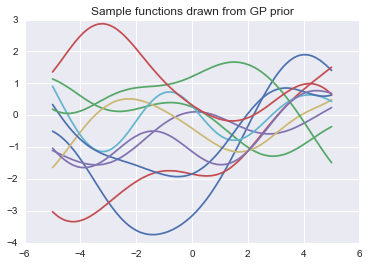

In [24]:
def SEkernel(a,b, sigma,l):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1)-2*np.dot(a,b.T)
    #return np.exp(-0.5 * sqdist) + sigma*np.eye(sqdist.shape[0])
    return sigma*np.exp(-0.5/l * sqdist)

n = 100
sigma = 2.7 # sigma_f hyperparam
l = 4.5 # length param
xtest = np.linspace(-5,5,n).reshape(-1,1)
K = SEkernel(xtest, xtest, sigma,l)

# generate data that obeys the kernel matrix to sample the prior
L = np.linalg.cholesky(K + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
plt.plot(xtest, f_prior)
plt.title("Sample functions drawn from GP prior")

## Prediction on Noiseless
Recall a GP defines a distribution over functions $p(f)$, where $f$ is a function mapping the input space $\boldsymbol{X}$ to the real number space. A GP prior probability distribution over functions allows us to perform **Bayesian inference**. Simply put, we will perform inference of continuous values (the unknown $f(x_i)$) with a GP prior. 

You may ask how is inference calculated as Bayesian inference requires computing the posterior or sampling the posterior if computationally intractable. GP regression has an simple and elegant prediction solution through the algebraic manipulation of the multivariate Gaussian. 

Typically, we would need to solve for Bayes'rule in order to compute the posterior predictive distribution for a new test point $x_*$. Rather than doing that, we will solve directly for the predictive posterior distribution using the properties of a multivariate Gaussian distribution. We go through the steps for predicting a **noiseless observations**. 

Recall the definition of a multivariate Gaussian from above, applying it to a GP has a joint distribution in the form:

$$
\begin{bmatrix}
    \boldsymbol{f}  \\
    \boldsymbol{f_*} 
\end{bmatrix}
\sim \mathcal{N} \Bigg (
\begin{bmatrix}
    \boldsymbol{\mu} \\
    \boldsymbol{\mu_*}
\end{bmatrix} ,
\begin{bmatrix}
    \Sigma & \Sigma_* \\
    \Sigma_*^T & \Sigma_{**}
\end{bmatrix}
\Bigg )
$$

where $\boldsymbol{f}$ is the known function values of the training and $\boldsymbol{f_*}$ is the set of function values corresponding to the test set inputs, $\boldsymbol{X_*}$. Using short hand notations, $\boldsymbol{\mu} = m(x_i)$ for $i=1,...,n$ for the training means and analogusly for the test means $\boldsymbol{\mu_*}$. *Recall, it is possible to set the means to 0.* The $\Sigma$s represent the covariances using a kernel: $\Sigma$ is the training set covariances, $\Sigma_*$ is the training-test set convariances, and $\Sigma_**$ is the test set covariances. 

To calculate the predictive posterior distribution, we need to restrict the joint prior distribution to contain only those functions which agree with the oserved data points. Using the marginalisation and conditioning properteries of a multivariate/joint distribution as shown above to our data, we obtain the following:

$$
\begin{align}
p(\boldsymbol{f_*}| \boldsymbol{X_*},\boldsymbol{X}, \boldsymbol{f}) &= \mathcal{N}(\boldsymbol{f_*}| \boldsymbol{\mu_*}, \boldsymbol{\Sigma_*}) \\
\boldsymbol{\mu_*} &= \boldsymbol{\mu}(\boldsymbol{X_*}) + \boldsymbol{K_*}^T\boldsymbol{K}^{-1}(\boldsymbol{f} - \boldsymbol{\mu}(\boldsymbol{X})) \\
\boldsymbol{\Sigma_*} &= \boldsymbol{K_{**}} -\boldsymbol{K_*}^T \boldsymbol{K}^{-1}\boldsymbol{K_*}  
\end{align}
$$

## Prediction with Noisy Observations

It is more realistic to model situations that we do not have access to function values, but the noisy versions $y =f(x) + \epsilon$. Assuming additive i.i.d Gaussian noise $\epsilon$ with variance $\sigma^2_n$, the GP prior on the noisy observations becomes

$$
cov(y_p, y_q) = \kappa(\boldsymbol{x_p}, \boldsymbol{x_q}) + \sigma^2_n \delta_{pq}
$$
or
$$
cov[\boldsymbol{y}|\boldsymbol{X}] = \boldsymbol{K} + \sigma^2_n \boldsymbol{I}_n
$$

where $\delta_{pq}$ is a Kronecker delta which is 1 if and only if $p=q$ and 0 otherwise.

We rewrite the joint distribution with noise as the following:

$$
\begin{bmatrix}
    \boldsymbol{y}  \\
    \boldsymbol{f_*} 
\end{bmatrix}
\sim \mathcal{N} \Bigg (
\begin{bmatrix}
    \boldsymbol{\mu} \\
    \boldsymbol{\mu_*}
\end{bmatrix} ,
\begin{bmatrix}
    \Sigma_y & \Sigma_* \\
    \Sigma_*^T & \Sigma_{**}
\end{bmatrix}
\Bigg )
$$
where $\Sigma_y = K(\boldsymbol{X},\boldsymbol{X}) + \sigma^2_n \boldsymbol{I}_n$ and $n$ is the number of test points.

Applying marginalisiation and conditioning achieve

$$
\begin{align}
p(\boldsymbol{f_*}| \boldsymbol{X_*},\boldsymbol{X}, \boldsymbol{f}) &= \mathcal{N}(\boldsymbol{f_*}| \boldsymbol{\mu_*}, \boldsymbol{\Sigma_*}) \\
\boldsymbol{\mu_*} &= \boldsymbol{K_*}^T \boldsymbol{K_y}^{-1} \boldsymbol{y}  \\
\boldsymbol{\Sigma_*} &= \boldsymbol{K_{**}} -\boldsymbol{K_*}^T \boldsymbol{K_y}^{-1}\boldsymbol{K_*}  
\end{align}
$$

In [27]:
import numpy as np 
import seaborn as sea
import scipy 
import matplotlib.pyplot as plt

np.random.seed(1234)

"""
Implementation of Gaussian Process Regression using a toy data set.
There is no optimisation such as gradient descent or MAP.

author: Quan Le, quale@cisco.com
"""

class GP(object):
    """
    The base GP class with functions to calculate the likelihoods.
    """

    def __init__(self, X, y, noise, sigma, l):
        """
        Initalise the GP with the following:

        X: the data in a matrix 
        y: labels
        noise: data variance
        sigma: kernel variance
        l: parmeter for the kernel length

        """

        self.X = X
        self.y = y
        self.noise = noise # sigma_f: var of the data
        self.sigma = sigma # sigma_n: var of the kernel to control the vertical variation 
        self.l = l # kernel length

        # compute the covariance matrix K(x,x)
        self.K = self.kernel(self.X, self.X)

    def kernel(self,a,b, l=None):
        """
        Squared Exponential Kernel where a and b are 1-D vectors 

        l: horizontal length 
        """
        if l == None:
            l = self.l

        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1)-2*np.dot(a,b.T)
        return self.sigma*np.exp(-0.5*sqdist/l**2)

    def log_likelihood(self):
        """
            Compute the negative log likelihood. Parts of the equation requires 
            matrix inversion which is 0(n^2) operation, so we use
            Cholesky decomposition.  
        """

        L = np.linalg.cholesky(self.K + self.noise*np.eye(self.K.shape[0]))
        a_temp = np.linalg.solve(L,y)
        alpha = np.linalg.solve(L.T, a_temp)

        neg_ll = -0.5*( np.dot(y.T, alpha) + \
            np.log(np.linalg.det(self.K + self.noise*np.eye(self.K.shape[0]))) + \
            self.K.shape[0]*np.log(2*np.pi) )

        return L, alpha, neg_ll


    def prediction(self, x_pred, L, alpha):
        """ Calculate the posterior p(f_star | y)"""

        K_star = self.kernel(x, x_pred)
        K_star_star = self.kernel(x_pred, x_pred)

        # calculate the prediction mu
        mu = np.dot(K_star.T, alpha)
        v_temp = np.linalg.solve(L, K_star)
        cov = K_star_star - np.dot(v_temp.T, v_temp)
        return mu, cov

    def sample_prior(self, x_pred, l=None):
        """
        Sample some functions from the prior with the test data from a kernel 
        using x_pred and the length argument.

        This means to generate some covariance in order to generate some random data 
        (the functions sampled) that obeys the properties of the matrix. 
    	"""

        K = self.kernel(x_pred, x_pred, l)                              # compute test kernel K
        L = np.linalg.cholesky(K + 1e-8*np.eye(x_pred.shape[0]))        # use Cholesky instead of matrix inversion
        prior = np.dot(L, np.random.normal(size=(x_pred.shape[0], 10))) # sample the prior 
        
        plt.plot(x_pred, prior)
        plt.title("Samples from the Prior")

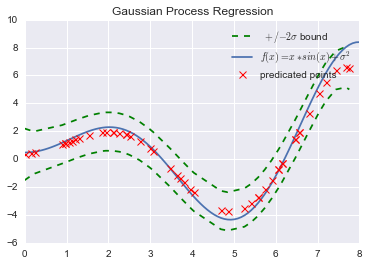

In [28]:
# kernel parameters
sigma = 2.5
l = 0.6

# data noise variance
sigma_f = 5.9    

# create the data 
f = lambda x: x*np.sin(x) + np.random.randn() 
x = np.linspace(0,8,100).reshape(-1,1)
y = f(x) # true points
x_pred = np.random.choice(x.flatten(), size=50)
x_pred = (np.sort(x_pred)).reshape(-1,1)        # sort and reshape for plotting

gp = GP(x, y, sigma_f, sigma, l)

# sample the prior
#gp.sample_prior(x_pred, l=1.8)

# predict
L, alpha, neg_ll = gp.log_likelihood()
mu, cov = gp.prediction(x_pred, L, alpha)

var = np.diag(cov).reshape(-1,1)                # get the variance
std = np.sqrt(var)                              # std for plotting


plt.plot(x_pred, mu+(2.*std) , 'g--', label=' $+/- 2 \sigma$ bound')
plt.plot(x_pred, mu-(2.*std) , 'g--')
plt.plot(x,y, label='$f(x) = x*sin(x) + \sigma^2$')
plt.plot(x_pred, mu, 'rx', mew=1, label='predicated points')
plt.legend(numpoints=1)
plt.title('Gaussian Process Regression')
plt.show()


# Discussion

In this tutorial, we have provided a mathematical walkthrough and implementation example of Gaussian Processes regression. We have shown how GPs can be used to specfiy non-linear regression. Our simple introduction has failed to mentioned many important aspects that makes GPs flexible. We only provide an example of one covariance function, SE, but there are many other kernels. Furthermore, we did not show to train the GP. Training the GP requires tuning the hyperparameters of the kernel or covariance function. This requires calculating the marginal likelihood which is shown in the code example (e.g. log_likelihood function). We would need to take the partial derivative for each hyperparameters (length and variance). We only discuss the regression problem, but GPs can be extended to classification. GPs are a powerful alternative to linear regression, capturing the variance in data. 

# References
http://newton.cx/~peter/wp/wp-content/uploads/2014/03/elem_gau_proc.html

http://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf

https://www.cs.ubc.ca/~hutter/EARG.shtml/earg/papers05/rasmussen_gps_in_ml.pdf

http://stats.stackexchange.com/questions/46588/why-are-gaussian-process-models-called-non-parametric

Rasmussen, Carl Edward. "Gaussian processes for machine learning." (2006).

Rasmussen, Carl Edward. "Gaussian processes in machine learning." Advanced lectures on machine learning. Springer Berlin Heidelberg, 2004. 63-71.

Wilson, Andrew Gordon. Covariance kernels for fast automatic pattern discovery and extrapolation with Gaussian processes. Diss. PhD thesis, University of Cambridge, 2014.

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.